In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional


In [93]:
tf.config.list_physical_devices('GPU') # Why 0...

[]

# EDA

Tagged entities:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [94]:
data = pd.read_csv("ner_datasetreference.csv", encoding="latin1")
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [95]:
data.nunique()

Sentence #    47959
Word          35177
POS              42
Tag              17
dtype: int64

In [96]:
data["Tag"].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [97]:
data.groupby("Tag")[["Word", "POS"]].count()

,Word,POS
Tag,,
B-art,402,402
B-eve,308,308
B-geo,37644,37644
B-gpe,15870,15870
B-nat,201,201
B-org,20143,20143
B-per,16990,16990
B-tim,20333,20333
I-art,297,297


In [98]:
data["POS"].unique()

array(['NNS', 'IN', 'VBP', 'VBN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'CC',
       'JJ', '.', 'VBD', 'WP', '``', 'CD', 'PRP', 'VBZ', 'POS', 'VBG',
       'RB', ',', 'WRB', 'PRP$', 'MD', 'WDT', 'JJR', ':', 'JJS', 'WP$',
       'RP', 'PDT', 'NNPS', 'EX', 'RBS', 'LRB', 'RRB', '$', 'RBR', ';',
       'UH', 'FW'], dtype=object)

In [99]:
data.isna().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

In [100]:
data[data["Word"].isna()].index.values

array([ 197658,  256026,  257069,  571211,  613777,  747019,  901758,
        903054,  944880, 1003438], dtype=int64)

In [101]:
idxs = data[data["Word"].isna()].index.values[0]
data.loc[idxs - 4:idxs + 4]

,Sentence #,Word,POS,Tag
197654,NaN,before,IN,O
197655,NaN,their,PRP$,O
197656,NaN,pardons,NNS,O
197657,NaN,.,.,O
197658,Sentence: 9047,NaN,NN,O
197659,NaN,of,IN,O
197660,NaN,the,DT,O
197661,NaN,32,CD,O
197662,NaN,freed,VBN,O


In [102]:
data.loc[data[data["Word"].isna()].index.values]

,Sentence #,Word,POS,Tag
197658,Sentence: 9047,NaN,NN,O
256026,Sentence: 11709,NaN,NN,O
257069,Sentence: 11759,NaN,NN,O
571211,Sentence: 26129,NaN,NN,O
613777,Sentence: 28049,NaN,NN,O
747019,Sentence: 34152,NaN,NN,O
901758,Sentence: 41181,NaN,NN,O
903054,Sentence: 41244,NaN,NN,O
944880,Sentence: 43177,NaN,NN,O
1003438,Sentence: 45887,NaN,NN,O


In [103]:
data["Sentence #"] = data["Sentence #"].ffill()
data["Word"] = data["Word"].bfill()
data.isna().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [104]:
"Sentence: 123"[10:]

'123'

In [105]:
# Convert sentence N to int
data["Sentence #"] = data["Sentence #"].apply(lambda x: x[10:]).astype(int)

In [106]:
# Get unuque words
words = data["Word"].unique().tolist()
words.append("ENDPAD")
num_words = len(words)

In [107]:
# Get unuque TAGs
tags = data["Tag"].unique().tolist()
num_tags = len(tags)

In [108]:
num_words, num_tags

(35178, 17)

In [109]:
# most common words
data['Word'].value_counts().nlargest(15)

Word
the     52573
.       47761
,       32754
of      26364
in      26323
to      23213
a       20481
and     19936
The     11313
's      10923
for      8498
has      7216
is       6746
on       6710
that     6301
Name: count, dtype: int64

In [110]:
data.sample(7)

,Sentence #,Word,POS,Tag
91651,4175,Marine,NN,I-org
981222,44863,.,.,O
259073,11855,for,IN,O
773443,35351,ahead,RB,O
523895,23960,and,CC,O
320320,14668,the,DT,O
320258,14665,23,CD,O


In [111]:
data.head(30)

,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O
5,1,through,IN,O
6,1,London,NNP,B-geo
7,1,to,TO,O
8,1,protest,VB,O
9,1,the,DT,O


In [112]:
# Get next sentence 
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [113]:
getter = SentenceGetter(data)
sentences = getter.sentences

C:\Users\dotpo\AppData\Local\Temp\ipykernel_12980\978829275.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [114]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [115]:
# Only positive int must be
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

 Distibution of the len of the sentences

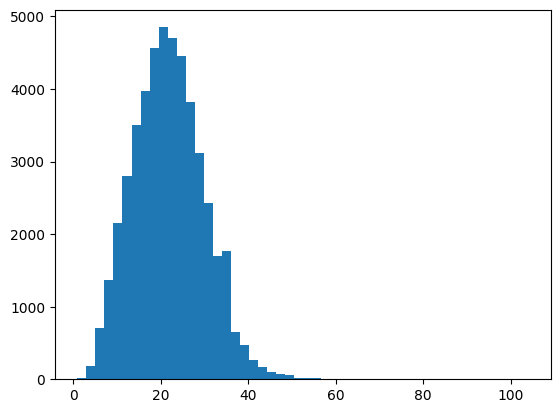

In [116]:
sentence_lengths = [len(s) for s in sentences]
plt.hist(sentence_lengths, bins=50)
plt.show()

In [117]:
# np.quantile(sentence_lengths, 0.95)

In [118]:
max_len = int(np.quantile(sentence_lengths, 0.95))

In [119]:
X = [[word2idx[w[0]] for w in s]
        for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s]
        for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [120]:
X[0]

array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    10,    16,     2,
          17,    18,    19,    20,    21,    22, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177])

In [121]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train model

In [122]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [123]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 35)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 35, 50)            1758900   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 35, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 35, 200)          120800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 35, 17)           3417      
 tributed)                                                       
                                                           

In [129]:
# import tensorflow.keras.backend as K
def custom_accuracy(y_test, preds_embeddings):
    y_test = y_test.numpy()
    preds_embeddings = preds_embeddings.numpy()
    pred_idxs = np.argmax(preds_embeddings, axis=-1)

    # Tag "O" has index 0
    nonzero_idx_true = np.nonzero(y_test)
    true_predicts = (pred_idxs[nonzero_idx_true] == y_test[nonzero_idx_true]).sum()

    return true_predicts / len(nonzero_idx_true[0])


In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              run_eagerly=True,
              metrics=["accuracy",
                       custom_accuracy,
                       ])

chkpt = ModelCheckpoint("model_weights", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

In [132]:
def custom_accuracy_val(y_test, preds_embeddings):
    pred_idxs = np.argmax(preds_embeddings, axis=-1)

    # Tag "O" has index 0
    nonzero_idx_true = np.nonzero(y_test)
    true_predicts = (pred_idxs[nonzero_idx_true] == y_test[nonzero_idx_true]).sum()

    return true_predicts / len(nonzero_idx_true[0])


# preds_embeddings = model.predict(x_test)
custom_accuracy_val(y_test, preds_embeddings)

0.8329646716804652